In [1]:
#Load modules
import datacube
import numpy as np
import xarray as xr
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import sys
from datacube.storage import masking
from datacube.utils import geometry
from datacube.helpers import ga_pq_fuser, write_geotiff
from datacube.virtual import construct_from_yaml
import datacube

dc = datacube.Datacube()

In [2]:
def run_yaml_load(Thequery):
    prod = construct_from_yaml("""
    transform: expressions
    output:
        Wetness_Tasseled :
            formula: 0.0315 * blue + 0.2021 * green + 0.3102 * red + 0.1594 * nir + -0.6806 * swir1 + -0.6109 * swir2
            dtype: float32
            nodata: -999
    input:
        transform: apply_mask
        mask_measurement_name: pixelquality
        input:
            transform: make_mask
            flags:
                cloud_acca: no_cloud
                cloud_fmask: no_cloud
                cloud_shadow_acca: no_cloud_shadow
                cloud_shadow_fmask: no_cloud_shadow
                blue_saturated: False
                green_saturated: False
                red_saturated: False
                nir_saturated: False
                swir1_saturated: False
                swir2_saturated: False
                contiguous: True 
            mask_measurement_name: pixelquality
            input:
                juxtapose:
                    - product: ls8_nbart_albers
                    - product: ls8_pq_albers""")
    Data = prod.load(dc, **Thequery)
    return Data

In [3]:

query = {

    # Mathoura Large
    # 'y': (-35.6545, -36.0320),
    # 'x': (144.8179, 145.4289),
    # lake dissapointment
    # 'y': (-23.2958, -23.410),
    # 'x': (123.0695, 123.230),
    # Pambula
    'y': (-36.900, -36.988),
    'x': (149.800, 149.925),


    'time': ('2017-01-01', '2017-12-31'),
    'crs': 'EPSG:4326',
    'output_crs': 'EPSG: 3577',
    'resolution': (-25, 25)
}

In [4]:
Tasseled_cap= run_yaml_load(query)
want_to_mask = (Tasseled_cap == -999).to_array(dim='variables').all(dim='variables')
Tasseled_cap = Tasseled_cap.where(~want_to_mask, np.NaN)
Tasseled_cap

<xarray.Dataset>
Dimensions:           (time: 68, x: 498, y: 449)
Coordinates:
  * time              (time) datetime64[ns] 2017-01-07T23:50:53 ... 2017-12-25T23:51:16
  * y                 (y) float64 -4.144e+06 -4.144e+06 ... -4.155e+06
  * x                 (x) float64 1.585e+06 1.585e+06 ... 1.597e+06 1.597e+06
Data variables:
    Wetness_Tasseled  (time, y, x) float32 nan nan nan nan ... nan nan nan nan
Attributes:
    crs:      EPSG: 3577

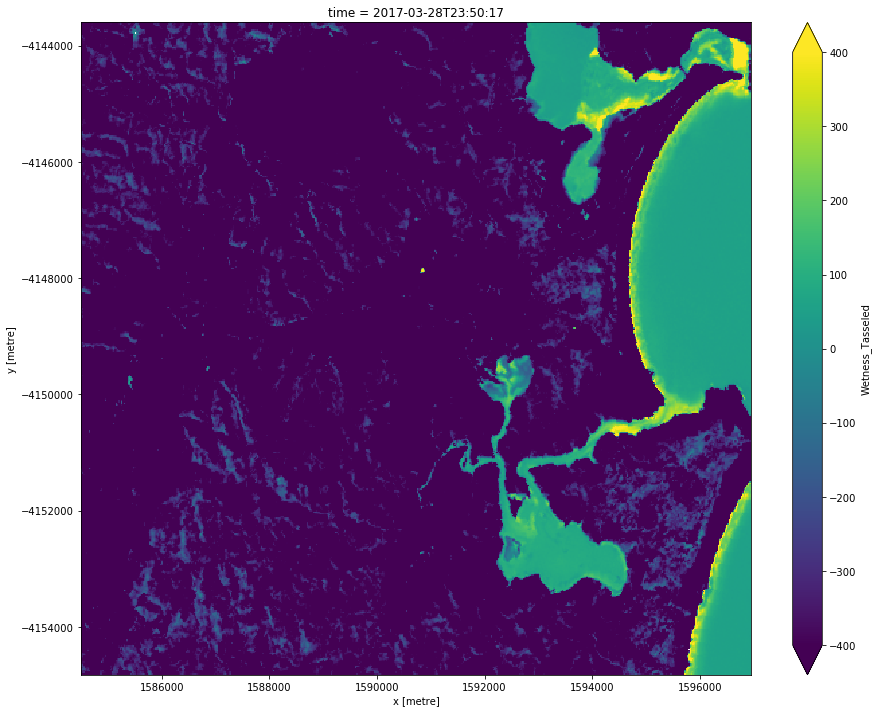

In [22]:
Tasseled_cap.Wetness_Tasseled.isel(time=15).plot(cmap='viridis', figsize =(15,12),vmin=-400,)

In [5]:
#load data
data_lst8 = dc.load(product='ls8_nbart_albers', group_by='solar_day', **query)
data_lst8.isel(time=0)

<xarray.Dataset>
Dimensions:          (x: 498, y: 449)
Coordinates:
    time             datetime64[ns] 2017-01-07T23:50:53
  * y                (y) float64 -4.144e+06 -4.144e+06 ... -4.155e+06 -4.155e+06
  * x                (x) float64 1.585e+06 1.585e+06 ... 1.597e+06 1.597e+06
Data variables:
    coastal_aerosol  (y, x) int16 2466 2493 2490 2470 ... 2339 2340 2341 2362
    blue             (y, x) int16 2235 2260 2271 2249 ... 2095 2100 2118 2136
    green            (y, x) int16 2200 2215 2213 2196 ... 1988 1986 1981 1985
    red              (y, x) int16 2120 2147 2142 2123 ... 1876 1870 1867 1881
    nir              (y, x) int16 3159 3183 3178 3147 ... 2156 2149 2157 2180
    swir1            (y, x) int16 1334 1355 1360 1349 1329 ... 994 993 987 983
    swir2            (y, x) int16 1171 1184 1185 1173 1159 ... 952 951 949 946
Attributes:
    crs:      EPSG: 3577

In [6]:
#turn terrain masked values form -999 to Nan

want_to_mask = (data_lst8 == -999).to_array(dim='variables').all(dim='variables')
terrain_out = data_lst8.where(~want_to_mask, np.NaN)

In [7]:
#load PG
sensor_pq = dc.load(product='ls8_pq_albers', fuse_func=ga_pq_fuser, group_by='solar_day', **query)
sensor_pq

<xarray.Dataset>
Dimensions:       (time: 45, x: 498, y: 449)
Coordinates:
  * time          (time) datetime64[ns] 2017-01-07T23:50:53 ... 2017-12-25T23:50:52.500000
  * y             (y) float64 -4.144e+06 -4.144e+06 ... -4.155e+06 -4.155e+06
  * x             (x) float64 1.585e+06 1.585e+06 ... 1.597e+06 1.597e+06
Data variables:
    pixelquality  (time, y, x) int16 13311 13311 13311 ... 12799 12799 12799
Attributes:
    crs:      EPSG: 3577

In [8]:
#Mask Cloud

#make Mask
good_quality = masking.make_mask(sensor_pq.pixelquality,
                                 cloud_acca='no_cloud',
                                 cloud_fmask='no_cloud',
                                 cloud_shadow_acca='no_cloud_shadow',
                                 cloud_shadow_fmask='no_cloud_shadow',
                                 blue_saturated=False,
                                 green_saturated=False,
                                 red_saturated=False,
                                 nir_saturated=False,
                                 swir1_saturated=False,
                                 swir2_saturated=False,
                                 contiguous=True)
good_quality

<xarray.DataArray 'pixelquality' (time: 45, y: 449, x: 498)>
array([[[False, False, ..., False, False],
        [False, False, ..., False, False],
        ...,
        [False, False, ..., False, False],
        [False, False, ..., False, False]],

       [[False, False, ..., False, False],
        [False, False, ..., False, False],
        ...,
        [False, False, ..., False, False],
        [False, False, ..., False, False]],

       ...,

       [[ True,  True, ...,  True,  True],
        [ True,  True, ...,  True, False],
        ...,
        [False, False, ..., False, False],
        [False, False, ..., False, False]],

       [[False, False, ..., False, False],
        [False, False, ..., False, False],
        ...,
        [False, False, ..., False, False],
        [False, False, ..., False, False]]])
Coordinates:
  * time     (time) datetime64[ns] 2017-01-07T23:50:53 ... 2017-12-25T23:50:52.500000
  * y        (y) float64 -4.144e+06 -4.144e+06 ... -4.155e+06 -4.155e+06
  * x 

In [9]:
#apply Mask
Masked_lst8_data = terrain_out.where(good_quality)

In [10]:
#make Fisher index

lst_fisher = 1.7204 +((171*Masked_lst8_data['green'])+(3*Masked_lst8_data['red'])-(70*Masked_lst8_data['nir'])-(45*Masked_lst8_data['swir1'])-(71*Masked_lst8_data['swir2']))/10000
lst_fisher

<xarray.DataArray (time: 45, y: 449, x: 498)>
array([[[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan]],

       [[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan]],

       ...,

       [[-14.476 , -13.9555, ..., -14.5664, -12.9539],
        [-13.9493, -14.5267, ..., -10.9112,      nan],
        ...,
        [     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan]],

       [[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan]]])
C

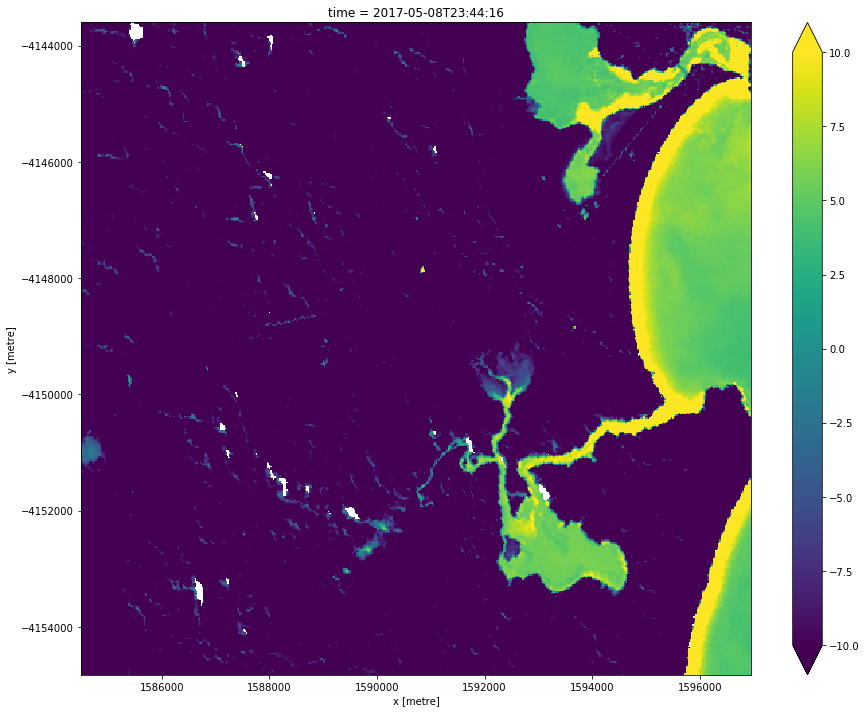

In [19]:
lst_fisher.isel(time=15).plot(cmap='viridis', figsize =(15,12),vmin=-10,)

In [12]:
inundated_veg_msk = (np.logical_and(lst_fisher>=-10,Tasseled_cap>=-400))
inundated_veg = lst_fisher.where(inundated_veg_msk==True,0)
inundated_veg = inundated_veg.where(inundated_veg_msk==False,1)

In [15]:
wet_frequency = inundated_veg.sum(dim='time')
wet_frequency

<xarray.Dataset>
Dimensions:           (x: 498, y: 449)
Coordinates:
  * y                 (y) float64 -4.144e+06 -4.144e+06 ... -4.155e+06
  * x                 (x) float64 1.585e+06 1.585e+06 ... 1.597e+06 1.597e+06
Data variables:
    Wetness_Tasseled  (y, x) float64 1.0 1.0 0.0 0.0 1.0 ... 26.0 26.0 26.0 26.0

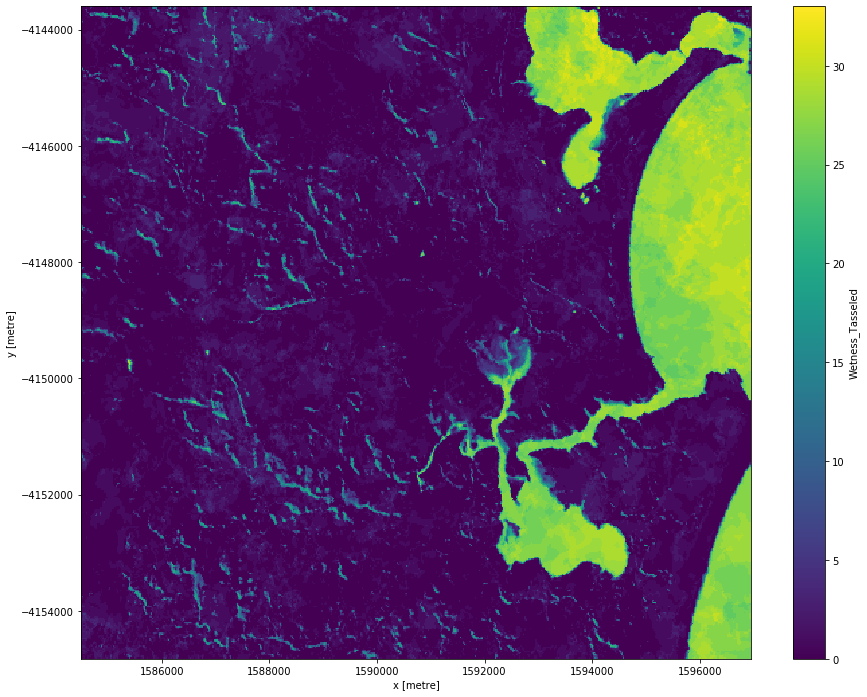

In [17]:
wet_frequency.Wetness_Tasseled.plot(cmap='viridis', figsize =(15,12))

In [ ]:
# wet_summery.Wetness_Tasseled.isel(time=35).plot(cmap='viridis', figsize =(15,12),vmin=-500, vmax=1)